# Load packages

In [0]:
# trimming related
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import re, string
from pprint import pprint
import time


# Link to GDrive

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
if 2==1:
  # 2. Create & upload a file text file.
  uploaded = drive.CreateFile({'title': 'Sample upload.txt'})
  uploaded.SetContentString('Sample upload file content')
  uploaded.Upload()
  print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [5]:
#https://drive.google.com/open?id=19c1xhHZrla2JngnGDaBzGXsUhJyC7WWo

if 1==1:
  #2. Get the file
  downloaded = drive.CreateFile({'id':'19c1xhHZrla2JngnGDaBzGXsUhJyC7WWo'}) # replace the id with id of file you want to access
  downloaded.GetContentFile('combined_trainingdata_20181013.tsv')  

  #3. Read file as panda dataframe
  import pandas as pd
  df = pd.read_csv('combined_trainingdata_20181108.tsv',sep='\t') 
  df.drop(labels=['Unnamed: 0'],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Verify data

In [11]:
df.shape

(961399, 11)

In [13]:
df.head(2)

,index,COMPLAINT_ID,CITY,COMPLAINT DATE,DEPT_311,CODE_311,CATEGORY_MAIN,CATEGORY_SUB,COMPLAINT_1,COMPLAINT_2,complaint
0,0,US_CHICAGO_1725,US_CHICAGO,10/03/2011,health_environment,permits issued by doe work order,environment,environment_general,QUESTIONABLE BUSINESS PRACTICES REGARDING OILS...,[INSPECTION LOG #: 1723 03-OCT-11 18:55:00] TH...,questionable business practices regarding oils...
1,1,US_CHICAGO_600301602,US_CHICAGO,07/14/2017,health_environment,illegal dumping work order,environment,environment_dumping,CONSTRUCTION/DEMOLITION DEBRIS DUMPED IN BACK ...,[INSPECTION LOG #: 3439804 14-JUL-17 09:45:00]...,constructiondemolition debris dumped back yard...


In [0]:
model_data=df[['CATEGORY_MAIN','CATEGORY_SUB','complaint']]

# Basic Modeling

In [0]:
# Load packages
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score

%matplotlib inline

** drop any category with less than 100 occurances**

In [21]:
model_data.dropna(axis=0,subset=['complaint'],inplace=True)
model_data=model_data[model_data.groupby('CATEGORY_SUB').CATEGORY_MAIN.transform(len) > 99]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
y_main= model_data['CATEGORY_MAIN']
y_sub= model_data['CATEGORY_SUB']
x= model_data['complaint']

count_vect = CountVectorizer()
x_counts = count_vect.fit_transform(x)
tfidf_transformer = TfidfTransformer()
x_tfidf = tfidf_transformer.fit_transform(x_counts)

In [0]:
#main categories
x_train_main, x_test_main, y_train_main, y_test_main = train_test_split( x_tfidf, y_main, test_size=0.2, random_state=412, stratify=y_main)

#sub categories
x_train_sub, x_test_sub, y_train_sub, y_test_sub = train_test_split( x_tfidf, y_sub, test_size=0.2, random_state=412, stratify=y_sub)

## Naive Bayes

In [0]:
modelNB_sub = MultinomialNB().fit(x_train_sub, y_train_sub)

In [25]:
display(modelNB_sub.predict(count_vect.transform(["fire escape"]))[0])
display(modelNB_sub.predict(count_vect.transform(["trash left in empty lot"]))[0])
display(modelNB_sub.predict(count_vect.transform(["broken window in abandoned house"]))[0])
display(modelNB_sub.predict(count_vect.transform(["graffiti"]))[0])

'housing_general'

'environment_garbage_collection'

'environment_abandoned_vehicle'

'vandalism_graffiti'

In [0]:
y_predict_NB_sub=modelNB_sub.predict(x_test_sub)

In [33]:
print('accuracy score:',accuracy_score(y_test_sub, y_predict_NB_sub, normalize=True, sample_weight=None))

print(classification_report(y_test_sub, y_predict_NB_sub))

accuracy score: 0.6994261753520724
                                 precision    recall  f1-score   support

        environemnt_dead_animal       0.00      0.00      0.00        54
     environment_abandoned_site       1.00      0.17      0.29       833
  environment_abandoned_vehicle       0.77      0.71      0.74      5043
      environment_air_pollution       0.68      0.91      0.78      3551
           environment_asbestos       1.00      0.04      0.07       542
        environment_dead_animal       0.93      0.59      0.73      1972
            environment_dumping       0.59      0.53      0.56      7219
 environment_garbage_collection       0.75      0.98      0.85     47408
            environment_general       0.95      0.06      0.11      1511
 environment_hazardous_material       0.92      0.20      0.32      1151
             environment_litter       0.98      0.15      0.26      2982
         environment_overgrowth       0.56      0.91      0.69     15871
          envir

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## SVM

In [34]:
modelsvc_sub = LinearSVC()
modelsvc_sub.fit(x_train_sub, y_train_sub)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [35]:
display(modelsvc_sub.predict(count_vect.transform(["fire escape"]))[0])
display(modelsvc_sub.predict(count_vect.transform(["trash left in empty lot"]))[0])
display(modelsvc_sub.predict(count_vect.transform(["broken window in abandoned house"]))[0])
display(modelsvc_sub.predict(count_vect.transform(["graffiti"]))[0])

'fire_general'

'environment_garbage_collection'

'housing_general'

'vandalism_graffiti'

In [0]:
y_predict_svc_sub = modelsvc_sub.predict(x_test_sub)

In [0]:


y_predict_svc_sub = pd.DataFrame(y_predict_svc_sub, dtype='str',columns=['predict_SUB'])['predict_SUB'].map(lambda x: x.replace('environemnt','environment'))

In [60]:
print('accuracy score:',accuracy_score(y_test_sub, y_predict_svc_sub, normalize=True, sample_weight=None))

print(classification_report(y_test_sub, y_predict_svc_sub))

accuracy score: 0.8115742980662681
                                 precision    recall  f1-score   support

        environemnt_dead_animal       0.00      0.00      0.00        54
     environment_abandoned_site       0.70      0.53      0.60       833
  environment_abandoned_vehicle       0.76      0.85      0.80      5043
      environment_air_pollution       0.85      0.89      0.87      3551
           environment_asbestos       0.91      0.94      0.93       542
        environment_dead_animal       0.85      0.93      0.89      1972
            environment_dumping       0.67      0.64      0.65      7219
 environment_garbage_collection       0.89      0.96      0.92     47408
            environment_general       0.65      0.41      0.50      1511
 environment_hazardous_material       0.78      0.73      0.76      1151
             environment_litter       0.69      0.50      0.58      2982
         environment_overgrowth       0.78      0.88      0.82     15871
          envir

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### let's convert to main category 
**and see how they do**

In [61]:
y_predict_svc_sub[:2]

0    environment_garbage_collection
1           environment_dead_animal
Name: predict_SUB, dtype: object

In [0]:
y_dummy=y_test_sub.map(lambda x: x.split('_')[0])


predict_dummy= y_predict_svc_sub.map(lambda x: x.split('_')[0])

In [64]:
print('accuracy score:',accuracy_score(y_dummy, predict_dummy, normalize=True, sample_weight=None))

print(classification_report(y_dummy, predict_dummy))

accuracy score: 0.8746794021402671
                precision    recall  f1-score   support

   environemnt       0.00      0.00      0.00        54
   environment       0.92      0.96      0.94     99855
          fire       0.71      0.72      0.72      1080
    governance       0.57      0.41      0.48     10278
       housing       0.78      0.76      0.77     10367
infrastructure       0.76      0.73      0.74      7108
      planning       0.86      0.71      0.78      7515
  publichealth       0.91      0.90      0.91      5215
   publicorder       0.74      0.69      0.71      3441
        street       0.88      0.89      0.88     39904
     vandalism       0.89      0.90      0.89      7402

   avg / total       0.87      0.87      0.87    192219



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


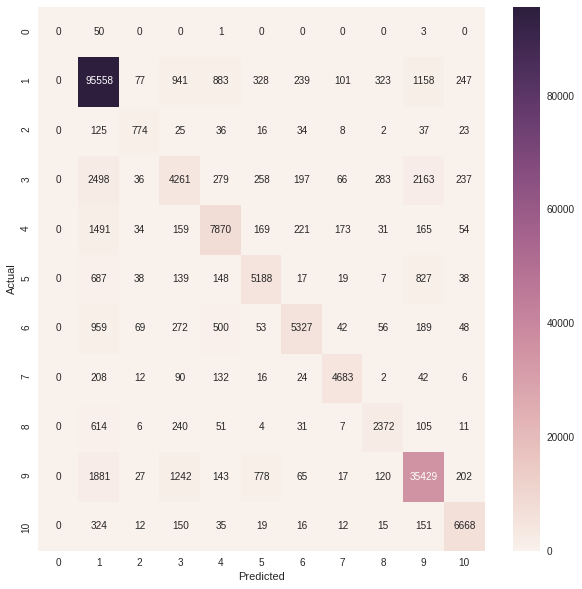

0.8746794021402671

In [68]:
#with MAIN classes
cm_svc = confusion_matrix(y_dummy, predict_dummy)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm_svc, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
display(accuracy_score(y_dummy, predict_dummy, normalize=True, sample_weight=None))